In [2]:
import imblearn
import pandas as pd
import numpy as np
import sklearn

## Load in the data and split into X and Y 

In [65]:
train_data = pd.read_csv("../data/label_df_train.csv")
val_data = pd.read_csv("../data/label_df_valid.csv")

train_data.head()

,transcript_id,transcript_position,mean_dwell_time_-1,mean_dwell_time_0,mean_dwell_time_1,weighted_mean_-1,weighted_mean_0,weighted_mean_1,weighted_sd_-1,weighted_sd_0,...,5-mer-2_G,5-mer-5_A,5-mer-5_C,5-mer-5_T,5-mer-6_A,5-mer-6_C,5-mer-6_G,5-mer-6_T,gene_id,label
0,ENST00000000233,244,0.008264,0.009373,0.007345,123.762870,125.793483,80.775369,0.515258,0.758299,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,ENSG00000004059,0
1,ENST00000000233,261,0.006609,0.006813,0.007710,109.924484,108.101783,94.108586,0.379088,0.356806,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,ENSG00000004059,0
2,ENST00000000233,316,0.007570,0.007416,0.007555,105.450998,99.426169,89.309704,0.297919,0.364248,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,ENSG00000004059,0
3,ENST00000000233,332,0.010620,0.008632,0.006101,129.548782,97.842815,89.096953,0.507180,0.250571,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,ENSG00000004059,0
4,ENST00000000233,368,0.010701,0.011479,0.010019,118.217577,121.925694,84.996204,0.659407,0.498776,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,ENSG00000004059,0


In [66]:
x_train = train_data.drop(columns = ["label","transcript_id","gene_id"])
y_train = train_data[['label']]
print(x_train.shape)
print(y_train.shape)

(97040, 26)
(97040, 1)


In [67]:
x_val = val_data.drop(columns = ["label","transcript_id","gene_id"])
y_val = val_data[["label"]]

# Ratio of positive to negative examples

In [68]:
positive_count = len(y_train[y_train['label'] == 1])
negative_count = len(y_train[y_train['label'] == 0])
print(positive_count/negative_count)

0.0474617618168669


## Oversample to 1:1


In [69]:
ros = imblearn.over_sampling.RandomOverSampler(random_state=4266)
x_resampled , y_resampled = ros.fit_resample(x_train,y_train)

In [70]:
print(x_resampled.shape)
print(y_resampled.shape)

(185286, 26)
(185286, 1)


In [26]:
positive_count = len(y_resampled[y_resampled['label'] == 1])
negative_count = len(y_resampled[y_resampled['label'] == 0])
print(positive_count/negative_count)

1.0


Test Model


In [33]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [33]:
# Create an MLP Classifier with desired hyperparameters
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, random_state=4266)
# Train the classifier on your training data
mlp_classifier.fit(x_resampled, y_resampled)

C:\Users\zacwo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zacwo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, random_state=4266)

In [44]:
y_pred = mlp_classifier.predict(x_val)
y_pred_prob = mlp_classifier.predict_proba(x_val)

In [42]:
accuracy = accuracy_score(y_val, y_pred)

print(accuracy)


0.7158238567626422


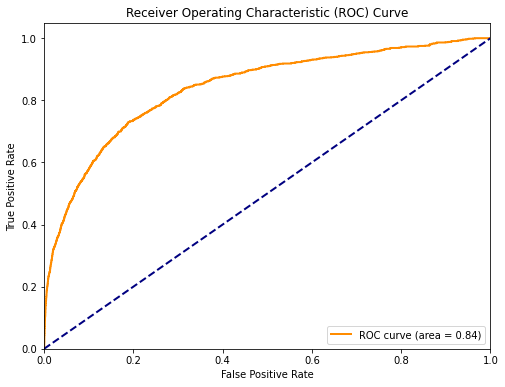

In [45]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_pred_prob[:, 1])

# Get ROC curve values
fpr, tpr, _ = roc_curve(y_val, y_pred_prob[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


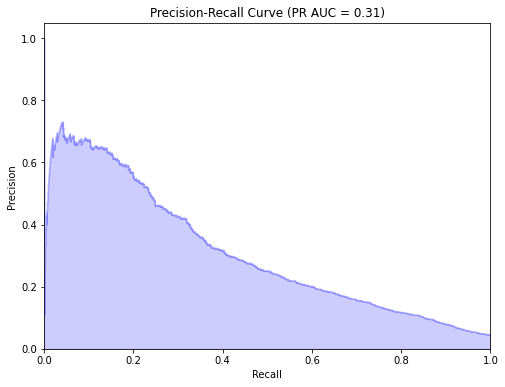

In [46]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Calculate PR AUC
pr_auc = average_precision_score(y_val, y_pred_prob[:, 1])

# Get precision-recall curve values
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob[:, 1])

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (PR AUC = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()


# Undersample 1:4

In [55]:
undersample = imblearn.under_sampling.NearMiss(sampling_strategy=0.25)
x_resampled, y_resampled = undersample.fit_resample(x_train, y_train)

In [56]:
print(x_resampled.shape)

(21985, 26)


In [57]:
positive_count = len(y_resampled[y_resampled['label'] == 1])
negative_count = len(y_resampled[y_resampled['label'] == 0])
print(positive_count/negative_count)

0.25


In [58]:
# Create an MLP Classifier with desired hyperparameters
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, random_state=4266)
# Train the classifier on your training data
mlp_classifier.fit(x_resampled, y_resampled)

C:\Users\zacwo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, random_state=4266)

In [59]:
y_pred = mlp_classifier.predict(x_val)
y_pred_prob = mlp_classifier.predict_proba(x_val)

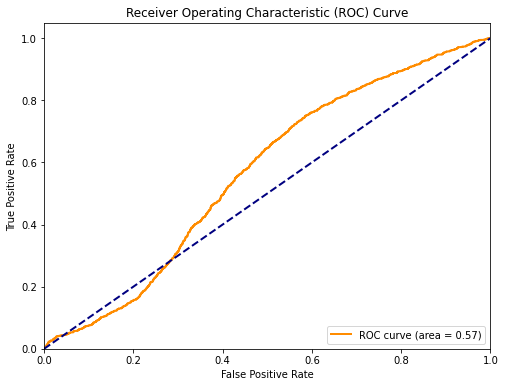

In [60]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_pred_prob[:, 1])

# Get ROC curve values
fpr, tpr, _ = roc_curve(y_val, y_pred_prob[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


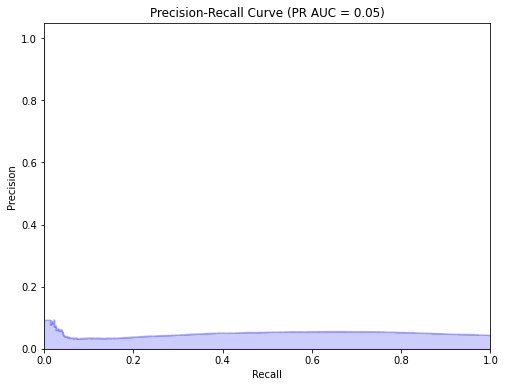

In [61]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Calculate PR AUC
pr_auc = average_precision_score(y_val, y_pred_prob[:, 1])

# Get precision-recall curve values
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob[:, 1])

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (PR AUC = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()


## Conclusive that undersampling is not effective by itself, since the absolute number of positive examples is too little.


## Try over and undersampling at the same time (SMOTEENN)

In [85]:
smote_enn = imblearn.combine.SMOTEENN(sampling_strategy=0.7) 


In [86]:
x_resampled, y_resampled = smote_enn.fit_resample(x_train, y_train)
print(x_resampled.shape)

(132127, 26)


In [87]:
positive_count = len(y_resampled[y_resampled['label'] == 1])
negative_count = len(y_resampled[y_resampled['label'] == 0])
print(positive_count/negative_count)

0.8200063363499869


In [88]:
# Create an MLP Classifier with desired hyperparameters
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, random_state=4266)
# Train the classifier on your training data
mlp_classifier.fit(x_resampled, y_resampled)

C:\Users\zacwo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zacwo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, random_state=4266)

In [89]:
y_pred = mlp_classifier.predict(x_val)
y_pred_prob = mlp_classifier.predict_proba(x_val)

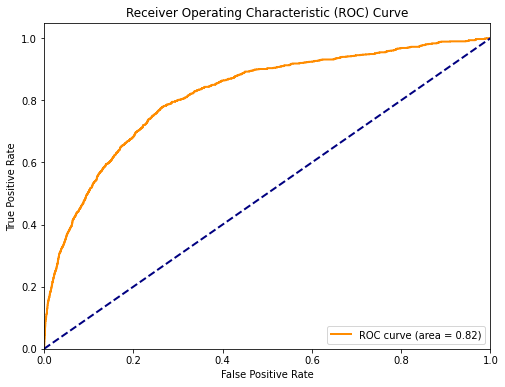

In [90]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_pred_prob[:, 1])

# Get ROC curve values
fpr, tpr, _ = roc_curve(y_val, y_pred_prob[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


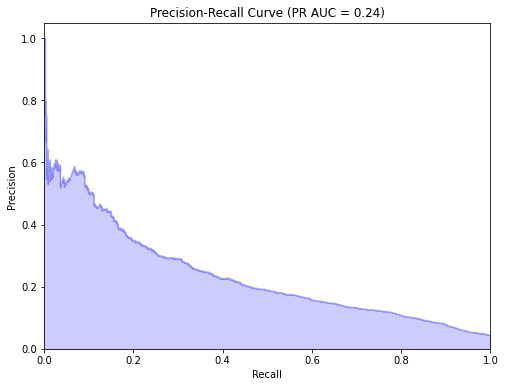

In [91]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Calculate PR AUC
pr_auc = average_precision_score(y_val, y_pred_prob[:, 1])

# Get precision-recall curve values
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob[:, 1])

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (PR AUC = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()


# Testing synthetic data create by sampling 15 reads per positive example

In [3]:
train_data = pd.read_csv("../data/train_synth_data.csv")
val_data = pd.read_csv("../data/test_synth_data.csv")

train_data.head()

,transcript_id,transcript_position,gene_id,label,dwell_time_-1,sd_-1,mean_-1,dwell_time_0,sd_0,mean_0,...,5-mer-1_G,5-mer-2_A,5-mer-2_G,5-mer-5_A,5-mer-5_C,5-mer-5_T,5-mer-6_A,5-mer-6_C,5-mer-6_T,5-mer-6_G
0,ENST00000393812,619,ENSG00000157593,1,0.006209,7.566667,118.466667,0.006304,3.510000,97.106667,...,1,1,0,0,1,0,0,0,0,1
1,ENST00000341116,1210,ENSG00000128309,1,0.013931,5.706667,115.533333,0.009088,4.492000,116.466667,...,1,0,1,1,0,0,0,1,0,0
2,ENST00000322157,3101,ENSG00000141279,1,0.009081,2.058000,101.920000,0.008111,3.222000,100.020000,...,0,1,0,0,1,0,1,0,0,0
3,ENST00000371696,924,ENSG00000169692,1,0.008301,3.338000,96.906667,0.007269,5.936667,119.400000,...,0,0,1,0,1,0,0,0,1,0
4,ENST00000343820,1438,ENSG00000177426,1,0.007910,6.236000,115.266667,0.010421,5.457333,113.266667,...,1,0,1,1,0,0,0,1,0,0


In [4]:
x_train = train_data.drop(columns = ["label","transcript_id","gene_id"])
y_train = train_data[['label']]
print(x_train.shape)
print(y_train.shape)

(186110, 26)
(186110, 1)


In [5]:
x_val = val_data.drop(columns = ["label","transcript_id","gene_id"])
y_val = val_data[["label"]]

In [6]:
positive_count = len(y_train[y_train['label'] == 1])
negative_count = len(y_train[y_train['label'] == 0])
print(positive_count/negative_count)

1.0


In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [13]:
# Create an MLP Classifier with desired hyperparameters
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, random_state=4266)
# Train the classifier on your training data
mlp_classifier.fit(x_train, y_train)

C:\Users\zacwo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zacwo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, random_state=4266)

In [16]:
y_pred = mlp_classifier.predict(x_val)
y_pred_prob = mlp_classifier.predict_proba(x_val)

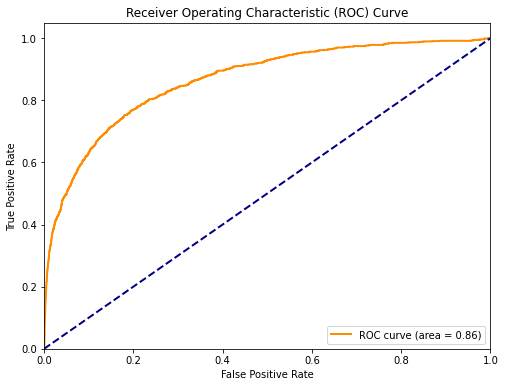

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_pred_prob[:, 1])

# Get ROC curve values
fpr, tpr, _ = roc_curve(y_val, y_pred_prob[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


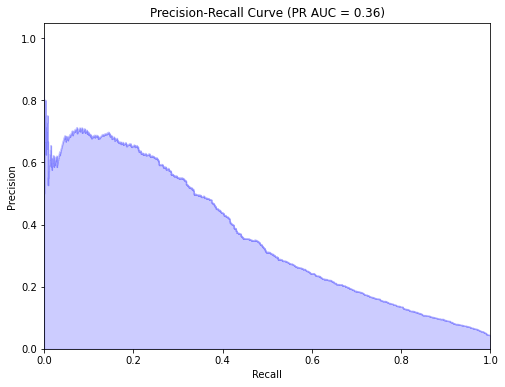

In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Calculate PR AUC
pr_auc = average_precision_score(y_val, y_pred_prob[:, 1])

# Get precision-recall curve values
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob[:, 1])

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (PR AUC = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()


Model test


In [51]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(8,4),tol=1e-24, max_iter = 500, verbose = 2,n_iter_no_change=50, random_state=4266)
mlp_clf.fit(x_train, y_train)

C:\Users\zacwo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 2.11484458
Iteration 2, loss = 0.62150853
Iteration 3, loss = 0.56794787
Iteration 4, loss = 0.54135226
Iteration 5, loss = 0.54219830
Iteration 6, loss = 0.53877747
Iteration 7, loss = 0.53919602
Iteration 8, loss = 0.52536272
Iteration 9, loss = 0.53527989
Iteration 10, loss = 0.52451926
Iteration 11, loss = 0.52120172
Iteration 12, loss = 0.52544190
Iteration 13, loss = 0.52543516
Iteration 14, loss = 0.53257621
Iteration 15, loss = 0.51932029
Iteration 16, loss = 0.52916014
Iteration 17, loss = 0.51870666
Iteration 18, loss = 0.52991909
Iteration 19, loss = 0.51731788
Iteration 20, loss = 0.51943753
Iteration 21, loss = 0.52093060
Iteration 22, loss = 0.51993106
Iteration 23, loss = 0.52626273
Iteration 24, loss = 0.52381110
Iteration 25, loss = 0.52037849
Iteration 26, loss = 0.51321812
Iteration 27, loss = 0.51337080
Iteration 28, loss = 0.51321224
Iteration 29, loss = 0.51152781
Iteration 30, loss = 0.50841296
Iteration 31, loss = 0.51207618
Iteration 32, los

C:\Users\zacwo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(8, 4), max_iter=500, n_iter_no_change=50,
              random_state=4266, tol=1e-24, verbose=2)

In [52]:
y_pred = mlp_clf.predict(x_val)
y_pred_prob = mlp_clf.predict_proba(x_val)

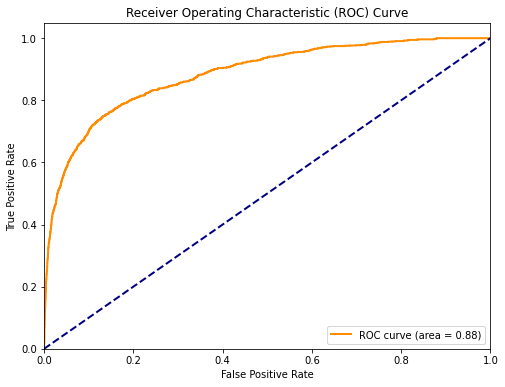

In [53]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_pred_prob[:, 1])

# Get ROC curve values
fpr, tpr, _ = roc_curve(y_val, y_pred_prob[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


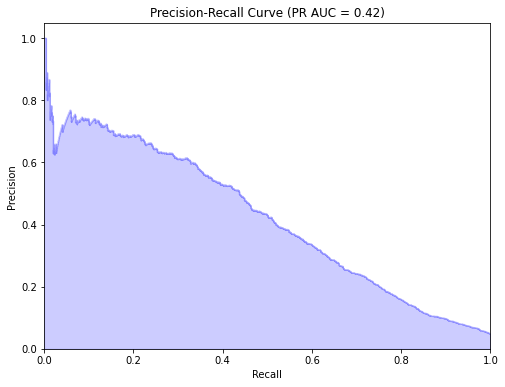

In [54]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Calculate PR AUC
pr_auc = average_precision_score(y_val, y_pred_prob[:, 1])

# Get precision-recall curve values
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob[:, 1])

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (PR AUC = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()
